# Data Management ET4015 - Exam report example, May 2021
### Group members:
- Javokhir Isomurodov, 876613@stud.unive.it, matriculation nr. 876613

In [ ]:
#we import all libraries
import os # needed to interact with the operating system (e.g. save/load a database)
import numpy as np # numerical library (linear algebra)
import pandas as pd # table manipulation. Based on numpy
from matplotlib import pyplot as plt # plots
import seaborn as sns # based on matplotlib. Very powerful plot library
import sqlite3 # needed to write SQL code in our notebooks and convert the results into Python tables. 

try:
    os.remove("database.db")
except OSError:
    pass

# the following stuff simplifies the interaction with SQL
conn = sqlite3.connect("database.db")
cur = conn.cursor()

def run_sql(sql_command): # executes a SQL code
    cur.execute(sql_command)
    conn.commit()
    if cur.description != None:
        col_names = [i[0] for i in cur.description]
        result = pd.DataFrame(cur.fetchall(), columns = col_names)
        result
        return result

def dataframe_to_table(df,table_name): # converts a dataframe into a SQL table in our database.
    df.to_sql(table_name, conn, if_exists='replace', index = False)
    conn.commit()

# 1. Introduction

This project explores different correlations regarding covid-19. Particularly, it will give interesting insights about relationship between vaccination numbers and covid cases/deaths. Also, there will be observations about the manufacturers of covid vaccines.

## 1.1 Datasets

We used the following datasets (included as csv files in the project folder):

*   https://github.com/datasets/covid-19/blob/main/data/countries-aggregated.csv
*   https://developers.google.com/public-data/docs/canonical/countries_csv
*   https://www.kaggle.com/tanuprabhu/population-by-country-2020
*   https://github.com/owid/covid-19-data/blob/master/public/data/vaccinations/vaccinations-by-manufacturer.csv
*   https://github.com/owid/covid-19-data/blob/master/public/data/vaccinations/vaccinations.csv

countries.csv is a table containing the names of countries and their latitude and longitude points in the world map.

countries-aggregated.csv has been renamed into "covid.csv" (to have a shorter name) and is a table containing covid-19 cases per country per day (updated daily).

population-by-country.csv has been renamed into "population.csv" and columns with country and land area have been renamed to "country" and "area" respectively.

vaccinations.csv has been renamed to "vax.csv" and its column "total_vaccinations" has been renamed to "total_vax", and its column "location" has been renamed to "country".

vaccinations-by-manufacturer.csv has been renamed to "vax_man" and its column "total_vaccinations" has been renamed to "total_vax" and its column "location" has been renamed to "country".

With the following commands we load the datasets into respective dataframes:

In [ ]:
countries_df = pd.read_csv("countries.csv")
covid_df = pd.read_csv("covid.csv")
population_df = pd.read_csv("population.csv")
vax_df = pd.read_csv("vax.csv")
vax_man_df = pd.read_csv("vax_man.csv")

# 2. Database Specification and Logical Design

In this section we discuss the database specification and its translation to a relational schema. The ER diagram can be found in the project's folder under the name "ER.pdf".

## 2.1 Specification

The database should store world countries. For each country we want to record a unique identifier (for example, a 2-letters unique identifier), the country name, population, land area (square kilometers), and
latitude/longitude. We furthermore want to store records of covid-19 cases. Each record is characterized by a
date and some statistics on the number of cumulative covid-19 cases registered up to that day (for example, distinguishing between confirmed, recovered, and deaths). The database should also store vaccination records. Each
vaccination record is characterized by a date and some vaccination statistics (for example, cumulative number of
vaccines/people vaccinated) up to that day. Each country keeps track of its own covid-19 cases and vaccination
records. Finally, we want to store vaccine manufacturers (e.g. Sinovac, Moderna, ...). Countries administer vaccines of one or more manufacturers to their population; for each day (whenever this information is available in
the raw data), we want to store the cumulative number of vaccines of a particular manufacturer that have been
administered by a country to its population.

## 2.2 Logical design

The logical design corresponding to our ER diagram is the following:

countries(<ins>id</ins>, name, population, area, latitude, longitude)

covid_record(<ins>day</ins>, <ins>country</ins>: fk to country(name), confirmed, recovered, deaths)

vax_record(<ins>day</ins>, <ins>country</ins>: fk to country(name), total_vax, people_vaccinated)

vax_man(<ins>day</ins>, <ins>country</ins>: fk to country(name), <ins>vaccine</ins>, total_vax)

We observe that entities covid_record, vax_record and vax_man are weak, thus country has to be part of their key.

# 3. Physical design

With the following SQL commands we create the schema of our database, translating the relational schema of section 2.2. We decided to add the following constraints:

covid_record: the number of confirmed covid cases, recoveries and deaths should be >= 0, and we decided to cascade changes (delete/update) made to countries.

vax_record: the number of total vaccination (total_vax) and people vaccinated should be >= 0, and we decided to cascade changes (delete/update) made to countries.

In [ ]:
run_sql('''
CREATE TABLE countries (
  id CHAR(2) PRIMARY KEY,
  name VARCHAR(50),
  population FLOAT,
  area FLOAT,
  latitude FLOAT,
  longitude FLOAT
);
''');

run_sql('''
CREATE TABLE covid_record (
  day DATE,
  country VARCHAR(50) references countries(name) on delete cascade on update cascade,
  confirmed FLOAT check (confirmed >= 0),
  recovered FLOAT check (confirmed >= 0),
  deaths FLOAT check (confirmed >= 0),
  primary key(day, country)
);
''');

run_sql('''
CREATE TABLE vax_record (
  day DATE,
  country VARCHAR(50),
  total_vax FLOAT check (total_vax >= 0),
  people_vaccinated FLOAT check (people_vaccinated >= 0),
  primary key(day, country)
  foreign key (country) references countries(name) on delete cascade on update cascade
);
''');

run_sql('''
CREATE TABLE vax_man (
  day DATE,
  country VARCHAR(50),
  vaccine VARCHAR(40),
  total_vax FLOAT check (total_vax >= 0),
  primary key(day, country, vaccine)
  foreign key (country) references countries(name) on delete cascade on update cascade
);
''');

# 4. Data insertion

First, we insert the CSV files into temporary SQL tables that will be later processed to create our database. 

In [ ]:
dataframe_to_table(countries_df,"countries_tmp") # create a table named "countries_tmp" (tmp stands for "temporary") with the content/schema of the dataframe countries_df
dataframe_to_table(covid_df,"covid_tmp") # create a table named "covid_tmp" with the content/schema of the dataframe covid_df
dataframe_to_table(population_df,"population_tmp")
dataframe_to_table(vax_df,"vax_tmp")
dataframe_to_table(vax_man_df,"vax_man_tmp") 

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


We check that the SQL temporary tables have been correctly created in our database:

In [ ]:
run_sql(''' 
SELECT *
FROM countries_tmp
''')

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla
...,...,...,...,...
240,YE,15.552727,48.516388,Yemen
241,YT,-12.827500,45.166244,Mayotte
242,ZA,-30.559482,22.937506,South Africa
243,ZM,-13.133897,27.849332,Zambia


In [ ]:
run_sql(''' 
SELECT *
FROM covid_tmp
''')

,Date,Country,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,0,0,0
1,2020-01-23,Afghanistan,0,0,0
2,2020-01-24,Afghanistan,0,0,0
3,2020-01-25,Afghanistan,0,0,0
4,2020-01-26,Afghanistan,0,0,0
...,...,...,...,...,...
115825,2021-09-02,Zimbabwe,125118,0,4449
115826,2021-09-03,Zimbabwe,125331,0,4457
115827,2021-09-04,Zimbabwe,125425,0,4466
115828,2021-09-05,Zimbabwe,125550,0,4482


In [ ]:
run_sql(''' 
SELECT *
FROM population_tmp
''')

,Country,Population,Yearly Change,Net Change,Density (P/Km^2),Area,Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1440297825,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,India,1382345085,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,United States,331341050,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,Indonesia,274021604,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,Pakistan,221612785,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %
...,...,...,...,...,...,...,...,...,...,...,...
230,Montserrat,4993,0.06 %,3,50,100,NaN,N.A.,N.A.,10 %,0.00 %
231,Falkland Islands,3497,3.05 %,103,0,12170,NaN,N.A.,N.A.,66 %,0.00 %
232,Niue,1628,0.68 %,11,6,260,NaN,N.A.,N.A.,46 %,0.00 %
233,Tokelau,1360,1.27 %,17,136,10,NaN,N.A.,N.A.,0 %,0.00 %


In [ ]:
run_sql(''' 
SELECT *
FROM vax_tmp
''')

,country,iso_code,date,total_vax,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46050,Zimbabwe,ZWE,2021-09-01,4270430.0,2615233.0,1655197.0,NaN,50606.0,36416.0,28.30,17.33,10.97,NaN,2413.0
46051,Zimbabwe,ZWE,2021-09-02,4323735.0,2649505.0,1674230.0,NaN,53305.0,39711.0,28.65,17.56,11.09,NaN,2631.0
46052,Zimbabwe,ZWE,2021-09-03,4372216.0,2681657.0,1690559.0,NaN,48481.0,42317.0,28.97,17.77,11.20,NaN,2804.0
46053,Zimbabwe,ZWE,2021-09-04,4400246.0,2698332.0,1701914.0,NaN,28030.0,41413.0,29.16,17.88,11.28,NaN,2744.0


In [ ]:
run_sql(''' 
SELECT *
FROM vax_man_tmp
''')

,country,date,vaccine,total_vax
0,Austria,2021-01-08,Johnson&Johnson,0
1,Austria,2021-01-08,Moderna,0
2,Austria,2021-01-08,Oxford/AstraZeneca,0
3,Austria,2021-01-08,Pfizer/BioNTech,31150
4,Austria,2021-01-15,Johnson&Johnson,0
...,...,...,...,...
15075,European Union,2021-09-07,Moderna,53445667
15076,European Union,2021-09-07,Oxford/AstraZeneca,67010382
15077,European Union,2021-09-07,Pfizer/BioNTech,380344010
15078,European Union,2021-09-07,Sinopharm/Beijing,2089836


Now, we choose 10 countries and include them in our countries table, while discluding all others.

logical design of countries is:
countries(<ins>id</ins>, name, population, area, latitude, longitude)

In [ ]:
run_sql(''' 
INSERT INTO countries
SELECT c.country, name, population, area, latitude, longitude
FROM countries_tmp  as c, population_tmp as p
WHERE name IN ("Italy", "United States", "South Korea", "Netherlands", "Japan", "Sweden", "Chile", "France", "Austria", "Switzerland")
    AND name = p.country
ORDER By name
''')

Now we check that countries have been properly inserted into the table:

In [ ]:
run_sql(''' 
SELECT *
FROM countries
''')

,id,name,population,area,latitude,longitude
0,AT,Austria,9015361.0,82409.0,47.516231,14.550072
1,CL,Chile,19144605.0,743532.0,-35.675147,-71.542969
2,FR,France,65298930.0,547557.0,46.227638,2.213749
3,IT,Italy,60446035.0,294140.0,41.871940,12.567380
4,JP,Japan,126407422.0,364555.0,36.204824,138.252924
5,NL,Netherlands,17141544.0,33720.0,52.132633,5.291266
6,KR,South Korea,51276977.0,97230.0,35.907757,127.766922
7,SE,Sweden,10110233.0,410340.0,60.128161,18.643501
8,CH,Switzerland,8665615.0,39516.0,46.818188,8.227512
9,US,United States,331341050.0,9147420.0,37.090240,-95.712891


The above query shows that there are exactly 10 countries in our database. Now, we insert data inside table covid_record. The schema of the table is:

covid_record(day, country: fk to country(name), confirmed, recovered, deaths)

We need to make sure that keys are not repeated. To be sure of this, one idea is to group rows by key and pick the maximum number of confirmed cases.

Another constraint: the number of confirmed cases should be >= 0. We check this using the clause HAVING.

In [ ]:
run_sql(''' 
INSERT INTO covid_record 
SELECT "Date", country, max(confirmed), max(recovered), max(deaths) -- note: "Date" must be put between double quotes because DATE is a reserved SQL word.
FROM covid_tmp, countries
WHERE covid_tmp.country = countries.name
GROUP BY "Date", country
HAVING max(confirmed) >= 0 -- needed for the check constraint. Note: this discards also NULL values
ORDER BY country
''')

We check that table has been created correctly (see distinct countries): 

In [ ]:
run_sql(''' 
SELECT DISTINCT country
FROM covid_record
''')

,country
0,Austria
1,Chile
2,France
3,Italy
4,Japan
5,Netherlands
6,Sweden
7,Switzerland


We see that the US and South Korea are missing from the list. Trying to solve this issue, we can see that covid_tmp doesn't have any country named "United States" or "South Korea". Rather, it stores the name of these countries in a different way (i.e: "US" and "Korea, South"):

In [ ]:
run_sql(''' 
SELECT DISTINCT country
FROM covid_tmp
WHERE country LIKE "%korea%"
''')

,Country
0,"Korea, South"


In [ ]:
run_sql(''' 
SELECT DISTINCT country
FROM covid_tmp
WHERE country IN ("United States", "United States of America", "US", "USA") -- we search in different versions of US
''')

,Country
0,US


Now, as we resolved the issue, we add the US and South Korea into the covid_record table and achieve consistency in the database. We first add these countries as "US" and "Korea, South", then change these names to "United States" and "South Korea" respectively so that they match with our country table:

In [ ]:
#add US and South Korea:
run_sql(''' 
INSERT INTO covid_record 
SELECT "Date", country, max(confirmed), max(recovered), max(deaths) -- note: "Date" must be put between double quotes because DATE is a reserved SQL word.
FROM covid_tmp
WHERE country in ("US", "Korea, South")
GROUP BY "Date", country
HAVING max(confirmed) >= 0 -- needed for the check constraint. Note: this discards also NULL values
ORDER BY country
''')

In [ ]:
#update the name for US:
run_sql(''' 
UPDATE covid_record
SET country = 'United States'
WHERE country = "US";
''')

#update the name for South Korea:
run_sql(''' 
UPDATE covid_record
SET country = 'South Korea'
WHERE country = "Korea, South";
''')

We check again and see that the table now contains data also about the US:

In [ ]:
run_sql(''' 
SELECT DISTINCT country
FROM covid_record
''')

,country
0,Austria
1,Chile
2,France
3,Italy
4,Japan
5,Netherlands
6,South Korea
7,Sweden
8,Switzerland
9,United States


Now, we insert data in our table vax_record. The schema of the table is:

vax_record(<ins>day</ins>, <ins>country</ins>: fk to country(name), total_vax, people_vaccinated)

As above, we avoid duplicating keys by using GROUP BY (if total_vax and people_vaccinated contain two rows with the same day/country, we pick the maximum number of total_vax and people_vaccinated), and we remove groups with negative number of flights by using HAVING.

In [ ]:
run_sql(''' 
INSERT INTO vax_record
SELECT "date", country, max(total_vax), max(people_vaccinated)
FROM vax_tmp, countries
WHERE vax_tmp.country = countries.name
GROUP BY "date", country
HAVING max(total_vax) >= 0 and max(people_vaccinated) >= 0 -- needed for the check constraint
ORDER BY country
''')

We check that the table has been correctly created:

In [ ]:
run_sql('''
SELECT *
FROM vax_record
''')

,day,country,total_vax,people_vaccinated
0,2020-12-27,Austria,749.0,749.0
1,2020-12-28,Austria,2067.0,2066.0
2,2020-12-29,Austria,3713.0,3712.0
3,2020-12-30,Austria,5089.0,5088.0
4,2020-12-31,Austria,5101.0,5100.0
...,...,...,...,...
1954,2021-08-31,United States,370212027.0,205026070.0
1955,2021-09-01,United States,371280129.0,205527578.0
1956,2021-09-02,United States,372116617.0,205911640.0
1957,2021-09-03,United States,373516809.0,206461869.0


Now, we insert data in our table vax_man. The schema of the table is:

vax_man(<ins>day</ins>, <ins>country</ins>: fk to country(name), <ins>vaccine</ins>, total_vax)

As above, we avoid duplicating keys by using GROUP BY (if total_vax contains two rows with the same day/country/vaccine, we pick the one with the maximum number of total_vax), and we remove groups with negative number of flights by using HAVING.

In [ ]:
run_sql(''' 
INSERT INTO vax_man
SELECT "date", country, vaccine, max(total_vax)
FROM vax_man_tmp, countries
WHERE country = name
GROUP BY "date", country, vaccine
HAVING max(total_vax) >= 0 -- needed for the check constraint
ORDER BY country
''')

We check that the table has been correctly created:

In [ ]:
run_sql('''
SELECT *
FROM vax_man
''')

,day,country,vaccine,total_vax
0,2021-01-08,Austria,Johnson&Johnson,0.0
1,2021-01-08,Austria,Moderna,0.0
2,2021-01-08,Austria,Oxford/AstraZeneca,0.0
3,2021-01-08,Austria,Pfizer/BioNTech,31150.0
4,2021-01-15,Austria,Johnson&Johnson,0.0
...,...,...,...,...
4967,2021-09-03,United States,Moderna,146379359.0
4968,2021-09-03,United States,Pfizer/BioNTech,212319148.0
4969,2021-09-04,United States,Johnson&Johnson,14492832.0
4970,2021-09-04,United States,Moderna,146657321.0


Now we can delete our temporary tables, since the tables of our database have been correctly created:

In [ ]:
run_sql('''
DROP TABLE countries_tmp
''')

In [ ]:
run_sql('''
DROP TABLE covid_tmp
''')

In [ ]:
run_sql('''
DROP TABLE population_tmp
''')

In [ ]:
run_sql('''
DROP TABLE vax_tmp
''')

In [ ]:
run_sql('''
DROP TABLE vax_man_tmp
''')

At this point we downloaded the database "database.db" (panel on the left) that is included in the project's folder. 

# 5. Queries

In this section we run some queries on our database to collect interesting statistics.

## 5.1 Query 1

For a country, consider the value VAX obtained by dividing the number of people vaccinated up to today by
the country’s population size. Return a list of all countries sorted by decreasing VAX (showing also the value
of VAX for each listed country). Careful: the numbers in the vaccination CSV are cumulative.

In [ ]:
run_sql(''' 
SELECT country, day, max(people_vaccinated) / population AS VAX
FROM vax_record, countries
WHERE country = name
GROUP BY country
''')

,country,day,VAX
0,Austria,2021-09-06,0.614987
1,Chile,2021-09-06,0.754776
2,France,2021-09-06,0.751472
3,Italy,2021-09-06,0.716094
4,Japan,2021-09-06,0.593841
5,Netherlands,2021-09-05,0.700156
6,South Korea,2021-09-06,0.599630
7,Sweden,2021-09-03,0.685883
8,Switzerland,2021-09-06,0.584308
9,United States,2021-09-04,0.624458


## Query 2

Find the country in the database that had the smallest number of confirmed covid cases per square kilometer
(up to today).


In [ ]:
run_sql('''
SELECT name, area / max(confirmed) AS covid_per_km   -- basically, max(confirmed) gives us the latest day available in the table
FROM countries, covid_record
WHERE name = country
GROUP BY name
ORDER BY covid_per_km ASC
''')

# the first row in the table is the answer for the query (i.e: Netherlands)

,name,covid_per_km
0,Netherlands,0.016924
1,Switzerland,0.050294
2,Italy,0.064296
3,France,0.079077
4,Austria,0.118147
5,United States,0.228581
6,Japan,0.230197
7,Sweden,0.362964
8,South Korea,0.369171
9,Chile,0.452952


## Query 3

Which country (among those in the database) in the northern hemisphere had the largest relative number of
covid deaths in October 2020? and in the southern hemisphere? (relative means that you have to divide the
covid cases by the country population size).


In [ ]:
#northern
run_sql('''
SELECT country, day, confirmed / population as rate
FROM covid_record, countries
WHERE day = "2020-10-31" and latitude > 0 and name = country
ORDER BY rate DESC
''')

#answer is the first row in our table (i.e: United States)

,country,day,rate
0,United States,2020-10-31,0.027663
1,France,2020-10-31,0.021660
2,Netherlands,2020-10-31,0.020864
3,Switzerland,2020-10-31,0.017800
4,Sweden,2020-10-31,0.012300
5,Austria,2020-10-31,0.011638
6,Italy,2020-10-31,0.011240
7,Japan,2020-10-31,0.000802
8,South Korea,2020-10-31,0.000519


In [ ]:
#southern
run_sql('''
SELECT country, day, confirmed / population
FROM covid_record, countries
WHERE day = "2020-10-31" and latitude < 0 and name = country
''')

# We only have Chile as a result of the query and this is also the asnwer.

,country,day,confirmed / population
0,Chile,2020-10-31,0.026653


## Query 4

Consider the rate R computed by dividing the (cumulative) number of covid cases by the (cumulative) number
of vaccinated people in a particular country on a particular day. Which country has the lowest R today?


In [ ]:
run_sql('''
SELECT c.country, c.day, max(confirmed) / max(people_vaccinated) as R
FROM covid_record as c, vax_record as v
WHERE c.country = v.country
GROUP BY c.country
ORDER BY R ASC
''')

#answer is the first row (i.e: South Korea)

,country,day,R
0,South Korea,2020-01-22,0.008566
1,Japan,2020-01-22,0.021097
2,Italy,2020-01-22,0.105690
3,Chile,2020-01-22,0.113601
4,Austria,2020-01-22,0.125806
5,France,2020-01-22,0.141110
6,Switzerland,2020-01-22,0.155172
7,Sweden,2020-01-22,0.163031
8,Netherlands,2020-01-22,0.166008
9,United States,2020-01-22,0.193411


## Query 5

Which country among those administering the Pfizer/BioNTech vaccine, has the lowest relative number of
covid deaths up to today (i.e. covid deaths divided by population size)?

Here, we have to connect three tables with each other in order to get the result:

In [ ]:
run_sql('''
SELECT c.country, c.day, max(deaths) / population as rate
FROM covid_record as c, vax_man as v, countries
WHERE c.country = v.country  AND v.country = name AND vaccine = "Pfizer/BioNTech"
GROUP BY name
ORDER BY rate ASC
''')

# First row is the answer: South Korea

,country,day,rate
0,South Korea,2021-09-06,0.000045
1,Japan,2021-09-06,0.000130
2,Netherlands,2021-09-06,0.001074
3,Austria,2021-09-06,0.001198
4,Switzerland,2021-09-02,0.001271
5,Sweden,2021-08-31,0.001453
6,France,2021-09-06,0.001770
7,Chile,2021-09-06,0.001938
8,United States,2021-09-06,0.001959
9,Italy,2021-09-06,0.002144


## Query 6

For each country, count the number of distinct manufacturers selling vaccines to that country (for example,
Chile administers the vaccines Sinovac and Pfizer/BioNTech, so this number for Chile is 2). Order countries
by this number (decreasing).

I assume that the data has been updated since then, and now countries are administering more vaccine types.

In [ ]:
run_sql('''
SELECT country, count(DISTINCT vaccine) as num
FROM vax_man
GROUP BY country
ORDER BY num DESC
''')

,country,num
0,Austria,4
1,Chile,4
2,France,4
3,Italy,4
4,Netherlands,4
5,South Korea,4
6,Sweden,3
7,United States,3
8,Japan,2
9,Switzerland,2


# 6. Data Visualization

## 6.1 number of vaccines versus covid cases in Italy and the US

We now study the number of vaccinated people and number of cumulative COVID cases in Italy and US from Sept 2020 until now, to discover if there is a relation between the two.

(IMPORTANT: Since we decided to keep just 10 countries in our database, Great Britain and Israel were not selected among those 10 countries. However, I think looking at the situation in Italy and the US is also interesting)

Idea: we write a SQL query that creates a dataframe with the following schema:

record(country, day, number, type)

where type can be either "vax" or "covid". Column "number" is the number of vaccines/covid cases on that day. Then we will filter data relative to Italy and the US in the period Sept.2020-now and visualize it. 

In [ ]:
run_sql('''
CREATE TABLE record(
  country VARCHAR(50),
  day DATE, 
  number INT,
  type VARCHAR(50)
)
''')

We start by inserting in this table all cumulative covid cases:

In [ ]:
run_sql('''
INSERT INTO record
SELECT country, day, confirmed, "covid_cases"
FROM covid_record
''')

Now we insert death records:

In [ ]:
run_sql('''
INSERT INTO record
SELECT country, day, deaths, "covid_deaths"
FROM covid_record
''')

Then, we insert all cumulative vaccination numbers:

In [ ]:
run_sql('''
INSERT INTO record
SELECT country, day, people_vaccinated, "vaccinated_people"
FROM vax_record
''')

We store the content of the table in a dataframe and visualize it:

In [ ]:
#for Italy
vax_cases_corr_it = run_sql('''
SELECT * 
FROM record
WHERE country = "Italy" and day >= "2020-09-01" -- selecting days after 2020 September
''');

#for US
vax_cases_corr_us = run_sql('''
SELECT * 
FROM record
WHERE country = "United States" and day >= "2020-09-01"
''');

#formating the days so that Seaborn can plot them nicely on the x axis
vax_cases_corr_it['day'] = pd.to_datetime(vax_cases_corr_it['day'], format = '%Y-%m-%d')
vax_cases_corr_us['day'] = pd.to_datetime(vax_cases_corr_us['day'], format = '%Y-%m-%d')

vax_cases_corr_it

,country,day,number,type
0,Italy,2020-09-01,270189,covid_cases
1,Italy,2020-09-02,271515,covid_cases
2,Italy,2020-09-03,272912,covid_cases
3,Italy,2020-09-04,274644,covid_cases
4,Italy,2020-09-05,276338,covid_cases
...,...,...,...,...
991,Italy,2021-09-02,42905918,vaccinated_people
992,Italy,2021-09-03,43021636,vaccinated_people
993,Italy,2021-09-04,43119705,vaccinated_people
994,Italy,2021-09-05,43179785,vaccinated_people


Finally, we can plot this data creating one line for "vaccine", one for "covid_cases" and one for deaths

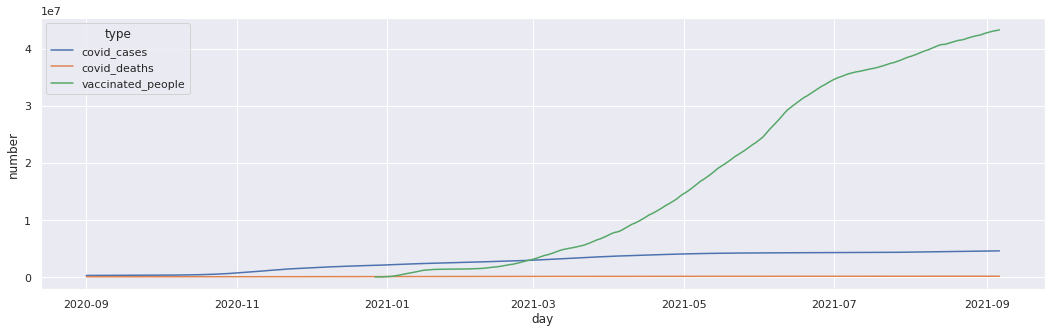

In [ ]:
#For Italy
sns.set(rc={'figure.figsize':(18,5)}) # change the plot size (width, height)
sns.lineplot(x='day', y='number', hue = 'type', data = vax_cases_corr_it)

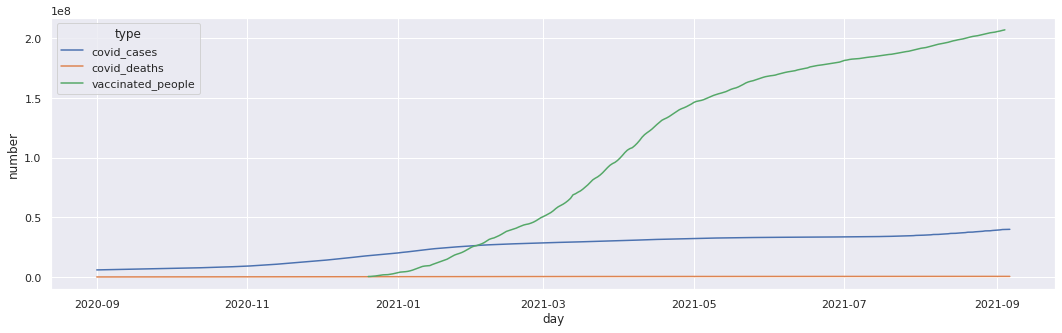

In [ ]:
#For the US
sns.set(rc={'figure.figsize':(18,5)}) # change the plot size (width, height)
sns.lineplot(x='day', y='number', hue = 'type', data = vax_cases_corr_us)

It seems that there indeed is a relation between number of vaccinated people and covid cases/deaths (discussed in section 7). We can also plot a scatterplot relating the two variables against each other.

First, with a SQL query we create a table (stored in a dataframe vax_vs_covid) with the following schema that connects the two datasets:

vax_vs_covid(day, people_vaccinated, covid)


In [ ]:
vax_vs_covid_it = run_sql('''
SELECT vax_record.day, people_vaccinated AS vax, confirmed AS covid
FROM vax_record, covid_record
WHERE vax_record.day = covid_record.day AND 
      vax_record.country = "Italy" AND 
      covid_record.country = "Italy" AND 
      covid_record.day >= "2020-09-01"
''')

vax_vs_covid_us = run_sql('''
SELECT vax_record.day, people_vaccinated AS vax, confirmed AS covid
FROM vax_record, covid_record
WHERE vax_record.day = covid_record.day AND 
      vax_record.country = "United States" AND 
      covid_record.country = "United States" AND 
      covid_record.day >= "2020-09-01"
''')

Now we create a scatterplot with this data:

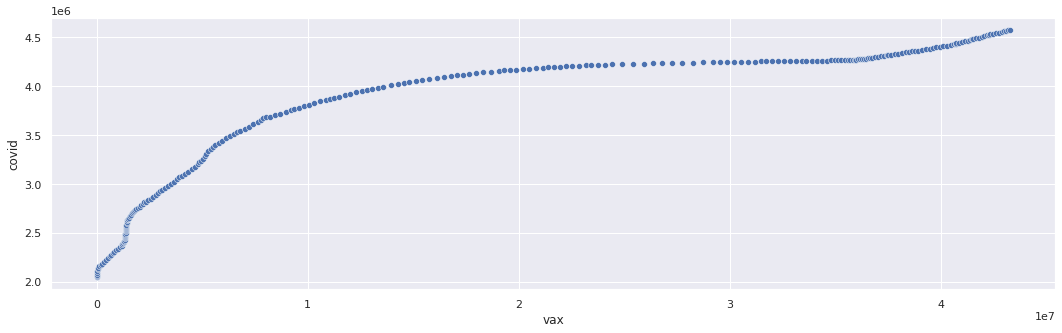

In [ ]:
sns.scatterplot(x="vax", y="covid", data=vax_vs_covid_it)

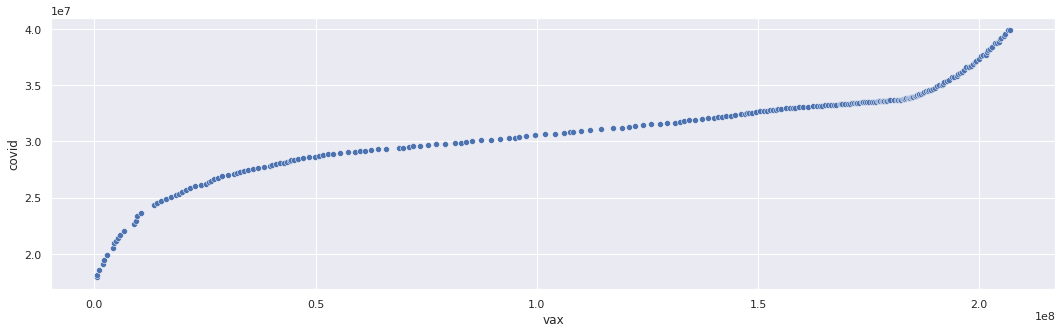

In [ ]:
sns.scatterplot(x="vax", y="covid", data=vax_vs_covid_us)

This scatterplot gives us false impression as if covid cases increase along vaccination numbers. The reason is that we have cumulative covid cases. It would make much more sense if we had daily covid cases

## 6.2 Types of vaccines used in the world in a time range

 Show the cumulative number of vaccinations administered in the world (as a function of time), clustered by
manufacturer (i.e. one line for Sinovac, one line for Pfizer/BioNTech, ...).


We can use only the vax_man table here without much complex queries:

In [ ]:
run_sql('''
SELECT vaccine, day, total_vax
FROM vax_man
WHERE vaccine = "Pfizer/BioNTech"
GROUP BY vaccine, day
''')

,vaccine,day,total_vax
0,Pfizer/BioNTech,2020-12-22,2.0
1,Pfizer/BioNTech,2020-12-23,427.0
2,Pfizer/BioNTech,2020-12-24,690.0
3,Pfizer/BioNTech,2020-12-25,690.0
4,Pfizer/BioNTech,2020-12-26,1126.0
...,...,...,...
255,Pfizer/BioNTech,2021-09-03,212319148.0
256,Pfizer/BioNTech,2021-09-04,212979842.0
257,Pfizer/BioNTech,2021-09-05,3270882.0
258,Pfizer/BioNTech,2021-09-06,3279275.0


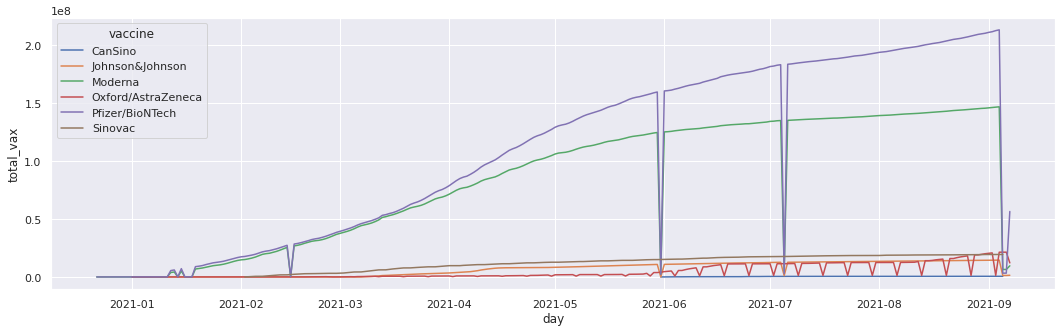

In [ ]:
vax_type = run_sql('''
SELECT vaccine, day, total_vax
FROM vax_man
GROUP BY vaccine, day
''')

#needed to tell Seaborn that column "day" contains dates:
vax_type['day'] = pd.to_datetime(vax_type['day'], format = '%Y-%m-%d')

sns.set(rc={'figure.figsize':(18,5)}) # change the plot size (width, height)
sns.lineplot(x='day', y='total_vax', hue = 'vaccine', data = vax_type)

This graph suggests very interesting patterns. Discussed in Section 7

## 6.3 Vaccination rates

Choose a few countries and plot their relative vaccination rates as a function of time in the last few months
(in one plot in order to compare them).

Here, we can refer back to Section 5.1. We will do something very similar to that query here. We group by country and day, and also leave only four countries (for simplicity of the graph):

In [ ]:
vax_rate = run_sql(''' 
SELECT country, day, people_vaccinated / population AS VAX
FROM vax_record, countries
WHERE country = name and country IN ("United States", "Italy", "Japan", "Chile")
GROUP BY country, day
''')

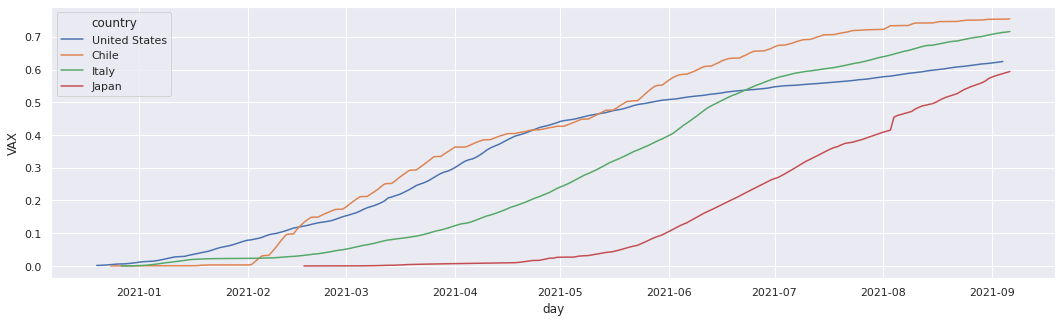

In [ ]:
#needed to tell Seaborn that column "day" contains dates:
vax_rate['day'] = pd.to_datetime(vax_rate['day'], format = '%Y-%m-%d')

sns.set(rc={'figure.figsize':(18,5)}) # change the plot size (width, height)
sns.lineplot(x='day', y='VAX', hue = 'country', data = vax_rate)

## 6.4 Additional observations (excess mortality)

I have decided to investigate the relationship between the officially confirmed covid deaths and the excess mortality rate reported by different countries with different socio-economic situations.

I will be using the data from Financial Times:
    https://raw.githubusercontent.com/Financial-Times/coronavirus-excess-mortality-data/master/data/ft_excess_deaths.csv

I will use data in comparison with the data we already have (i.e: covid.csv).

In detail, I want to see the realtionship in a lineplot between excess death and confirmed covid deaths.

I first create a new table named excess_mort (similar structure to the table from Section 6.1):

(logical design: excess_mort(day, country, confirmed_death, excess_death))

In [ ]:
run_sql('''
CREATE TABLE excess_mort (
  day DATE,
  country VARCHAR(50) references countries(name) on delete cascade on update cascade,
  num INT,
  type VARCHAR(20),
  primary key(day, country, type)
);
''');

Now I will read the csv from the source and store it as "data":

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/Financial-Times/coronavirus-excess-mortality-data/master/data/ft_excess_deaths.csv")

Convert data into SQL table:

In [ ]:
dataframe_to_table(data, "data")

In [ ]:
run_sql('''
SELECT *
FROM data
''')

,country,region,period,year,month,week,date,deaths,expected_deaths,excess_deaths,total_excess_deaths_pct
0,Albania,Albania,month,2015,1.0,NaN,2015-01-31,2490.0,NaN,NaN,42.547724
1,Albania,Albania,month,2015,2.0,NaN,2015-02-28,2139.0,NaN,NaN,42.547724
2,Albania,Albania,month,2015,3.0,NaN,2015-03-31,2051.0,NaN,NaN,42.547724
3,Albania,Albania,month,2015,4.0,NaN,2015-04-30,1906.0,NaN,NaN,42.547724
4,Albania,Albania,month,2015,5.0,NaN,2015-05-31,1709.0,NaN,NaN,42.547724
...,...,...,...,...,...,...,...,...,...,...,...
109407,Uzbekistan,Uzbekistan,month,2020,11.0,NaN,2020-11-30,14204.0,12813.071935,1390.928065,13.257817
109408,Uzbekistan,Uzbekistan,month,2020,12.0,NaN,2020-12-31,19938.0,18446.674288,1491.325712,13.257817
109409,Uzbekistan,Uzbekistan,month,2021,1.0,NaN,2021-01-31,11921.0,10205.343235,1715.656765,13.257817
109410,Uzbekistan,Uzbekistan,month,2021,2.0,NaN,2021-02-28,14002.0,13471.061201,530.938799,13.257817


At this point, I will recreate that covid_tmp dataframe I dropped a while ago:

In [ ]:
dataframe_to_table(covid_df,"covid_tmp") 

Next, I will insert selected data into my excess_mort table. I have decided to select a few Nordic countries and compare them to Russia and Uzbekistan. First I insert values from covid_tmp:

In [ ]:
run_sql('''
INSERT INTO excess_mort
SELECT "date", country, max(deaths), "reported_deaths" 
FROM covid_tmp
WHERE country IN ("Norway", "Denmark", "Sweden", "Russia", "Uzbekistan") AND "date" >= "2020-03-01"
GROUP BY "date", country
HAVING max(deaths) >= 0
''')

Now, insert values from table "data":

In [ ]:
run_sql('''
INSERT INTO excess_mort
SELECT "date", country, excess_deaths, "excess_death" 
FROM data
WHERE country IN ("Norway", "Denmark", "Sweden", "Russia", "Uzbekistan") AND "date" >= "2020-03-01"
GROUP BY "date", country
''')

Create a data fram out of this table:

In [ ]:
corr_df = run_sql('''
SELECT * 
FROM excess_mort
''')

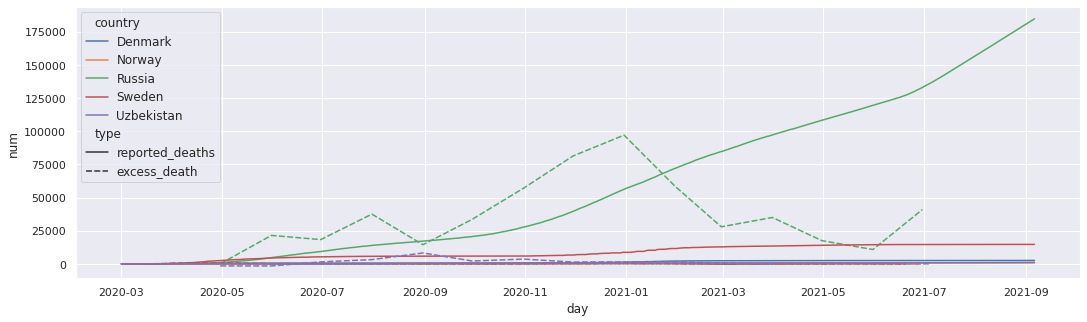

In [ ]:
corr_df['day'] = pd.to_datetime(corr_df['day'], format = '%Y-%m-%d')

sns.set(rc={'figure.figsize':(18,5)}) # change the plot size (width, height)
sns.lineplot(x='day', y='num', hue = 'country', style='type', data = corr_df)

Unfortunately, the graph does not seem to be an insightful one. The reason as I figured out is becuase we have cumulative covid deaths, while the excess death is clustered into weaks or months. Did we have such clustered data available, the results would be much mor interesting

# 7. Discussion

The relationship we obeserved in section 6.1 confirms that there is indeed a correlation between vaccination numbers and covid cases/deaths. As seen in the graph, with the start of vaccination campaigns, the covid cases and covid deaths started to plateau. Until then, they were in constatnt increase. Also, the graph shows that vaccination numbers are growing way too fast than covid cases, which could be interpreted as a success of the vaccination campaigns in both countries.

As for the visual graphs of the section 6.2 about the vaccine manufacturers, it is particularly interesting because of a few reasons. First, we can observe that the most popular vaccine in the world has been Pfizer/BioNTech. Also, the lineplot shows us that Moderna, Pfizer and AstraZeneca vaccines constantly fall in number by following a certain pattern. Exploring the reason behind this falls is very desirable for further research into the topic. And finally, we can see that the Pfizer vaccine is undergoing another steep fall in numbers (on Sept 6th, it went down 10 times in number compared to a day before). As a prediction, it can be attributed, among other things, to production and logistic aspects.

The graph of section 6.3 illustrates that all four countries are constantly vaccinating more and more percentage of their population. It also shows that all countries have already vaccinated more than 60% of their population (in the case of Chile, it is over 70% already) 

Section 6.4. In this section, my initial plan was to find out if there were any falsified numbers being reported by some countries. To identify this, I tried to use the excess mortality data from different countries and compare those results against officially reported covid deaths. 